# Table of Contents

- **13. Final Model**
- **14. Final Summary**

In [ ]:
## Set up Environment

# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import math
import time
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
from IPython.display import Image
from contextlib import contextmanager
import os
print('CWD is ',os.getcwd())

# Vis Libs..
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Libs..
import re
from gensim import corpora, models
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

# ML Libs...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder,FunctionTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import GridSearchCV


# DL Libs..
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input , Dropout, Flatten,concatenate,LSTM
from tensorflow.keras.layers import Embedding
import tensorflow.keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

CWD is  /content


# **13. Final Models**

## 13.1. Setup Colab Environment

In [ ]:
'''
Code below sets up Google Colab to load the input files from
Google Drive and can output files as well
'''

# Colab Libs...
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/Mercari Price Prediction/2. Processing/storage')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  /content/gdrive/MyDrive/Mercari Price Prediction/2. Processing/storage


## 13.2 Load Data From GDrive


In [ ]:
import pickle
file = open('df_train_model', 'rb')
df_train_model = pickle.load(file)
file.close()

file = open('df_test_model', 'rb')
df_test_model = pickle.load(file)
file.close()

print(df_train_model.shape,"\n",df_test_model.shape)

(1111901, 8) 
 (370634, 8)


In [ ]:
df_train_model.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
720995,720995,Advantage ll 6pk extra large dog 55lbs+,1,Other/Pet Supplies/Dogs,Advantage,50.0,1,6 month supply of advantage II start working o...
542483,542483,Sheer love Victoria secret travel set,1,Women/Other/Other,Victoria's Secret,19.0,0,Never used Great for Christmas presents(: No f...
1207045,1207045,Red Cherry Lashes 2-pack,1,Beauty/Makeup/Eyes,Red Cherry,5.0,1,✨✈️FREE Shipping!!✨✈️ Brand new wispy Red Cher...
1081237,1081237,Lularoe OS pink camera leggings,1,"Women/Athletic Apparel/Pants, Tights, Leggings",NaN,42.0,1,Brand new OS pink camera leggings. Made in Chi...
199059,199059,Lacey Flowy Red Dress,1,Women/Dresses/Knee-Length,Papaya,14.0,0,This dress is from papaya I just found it whil...


## 13.3 Functions for Data Encodings and Preparation


In [ ]:
'''
Code for Text Cleaning & Preprocessing Stage
'''
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# Removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

def text_preprocess(data):
    preprocessed = []
    # tqdm is for printing the status bar
    for sentance in tqdm_notebook(data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # stop word removal
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [ ]:
'''
This Function concatenates text features from item-name,brand,category,description to create
the concatenated text feature.
'''

def data_preprocess(df):
    df['name'] = df['name'].fillna('') + ' ' + df['brand_name'].fillna('')
    df['text'] = (df['item_description'].fillna('') + ' ' + df['name'] + ' ' + df['category_name'].fillna(''))
    return df[['name', 'text', 'shipping', 'item_condition_id','price']]

In [ ]:
'''
This Function takes in train,test datasets as input and returns
feature transforms - Tfidfvectorizer,Onehotencoder,etc. and
returns concatenated feature (hstack) of X_train,X_test,y_train,y_test as output.
'''

def data_encoder(train,test):

    # Text Encoding for Names...
    vect_name = TfidfVectorizer(max_features=100000, token_pattern='\w+', dtype=np.float32)
    train_name  = vect_name.fit_transform(train['name'].values)
    test_name = vect_name.transform(test['name'].values)

    # Text Encoding for Text...
    vect_text = TfidfVectorizer(max_features=100000, token_pattern='\w+', ngram_range=(1, 2), dtype=np.float32)
    train_text  = vect_text.fit_transform(train['text'].values)
    test_text = vect_text.transform(test['text'].values)

    # Encoding for Shipping, Item Condition ID...
    train_dummies = scipy.sparse.csr_matrix(pd.get_dummies(train[["item_condition_id", "shipping"]], sparse = True).values)
    test_dummies = scipy.sparse.csr_matrix(pd.get_dummies(test[["item_condition_id", "shipping"]], sparse = True).values)

    # Final Feature Stack for X_train,X_test
    X_train = scipy.sparse.hstack((train_name, train_text, train_dummies)).tocsr().astype('float32')
    X_test = scipy.sparse.hstack((test_name, test_text, test_dummies)).tocsr().astype('float32')

    # Final Outputs.. y_train,y_test
    global y_scaler
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(np.log1p(train['price'].values.reshape(-1, 1)))
    y_test = y_scaler.transform(np.log1p(test['price'].values.reshape(-1, 1)))

    return X_train,X_test,y_train,y_test

In [ ]:
'''Function creates a concatenated feature stack of item-name,description,brand,category columns'''

def text_concatenate(df):
    df['text'] = (df['name'].astype(str).fillna('') + ' ' + df['brand_name'].astype(str).fillna('') + ' ' +
                df['item_description'].astype(str).fillna('') + " " + df['category_name'].astype(str).fillna(''))
    return df['text']

In [ ]:
'''Function creates a concatenated feature stack of item-name,description,brand,category columns'''

def text_concatenate(df):
    df['text'] = (df['name'].astype(str).fillna('') + ' ' + df['brand_name'].astype(str).fillna('') + ' ' +
                df['item_description'].astype(str).fillna('') + " " + df['category_name'].astype(str).fillna(''))
    return df['text']

In [ ]:
'''
This Code uses Keras tokeizer to create Word Tokens from the Text Vocabulary,
it takes in train,test text data as input,
returns keras tokenizer and tokeized train,test datasets
'''


def text_tokenize(train,test):
    t = Tokenizer()
    t.fit_on_texts(train)
    #print('Total number of words in the document are ',len(t.word_index) + 1)
    train_tokenized = t.texts_to_sequences(train)
    test_tokenized = t.texts_to_sequences(test)
    return train_tokenized,test_tokenized,t

In [ ]:
'''
This Code takes train,test data and performs Pre-padding with (max_length= sl)
which can be input as required
'''

def text_padding(train,test,sl):
    padded_train_text = pad_sequences(train, maxlen = sl, padding='pre')
    padded_test_text = pad_sequences(test, maxlen = sl, padding='pre')
    return padded_train_text,padded_test_text

In [ ]:
'''This function takes in Text sentences data and performs BOW/TF - IDF
vectorization based on parameters input including ngrmas, min_df, max_features etc'''


def text_encoder(train, test, vect_type, params):
    vectorizer = CountVectorizer(ngram_range=params[0],
                                 min_df=params[1],
                                 max_df=params[2],
                                 max_features=params[3]) if vect_type == 'BOW' else TfidfVectorizer(ngram_range=params[0],
                                                                                                    min_df=params[1],
                                                                                                    max_df=params[2],
                                                                                                    max_features=params[3])
    train_transform = vectorizer.fit_transform(train)
    test_transform = vectorizer.transform(test)
    feat_names = vectorizer.get_feature_names_out()
    return train_transform, test_transform, feat_names

In [ ]:
'''This Function takes in train and test data
and performs One Hot Encodings on Shipping, Item Condition ID
by creating Dummay variable Encodings'''

def dummy_encoder(train,test):
    train_transform = scipy.sparse.csr_matrix(pd.get_dummies(train[["item_condition_id",
                                                                         "shipping"]], sparse = True).values)
    test_transform = scipy.sparse.csr_matrix(pd.get_dummies(test[["item_condition_id",
                                                                         "shipping"]], sparse = True).values)
    return train_transform,test_transform

In [ ]:
'''This Function takes in train, test data and
performs LabelBinarizer encodings on the brand_name column'''

def brand_encoder(train,test):
    vect = LabelBinarizer(sparse_output=True)
    train_transform = vect.fit_transform(train["brand_name"])
    test_transform = vect.transform(test["brand_name"])
    return train_transform,test_transform

In [ ]:
'''This Function takes in train and test data
and performs One Hot Encodings using countvectorizer
features on categorical data after using '/' delimiter splitter '''

def category_encoder(train,test):
    unique_categories = pd.Series("/".join(train["category_name"].unique().astype("str")).split("/")).unique()
    count_category = CountVectorizer(vocabulary = unique_categories,lowercase = False,binary = True)
    train_transform = count_category.fit_transform(train["category_name"])
    test_transform = count_category.transform(test['category_name'])
    return train_transform,test_transform

In [ ]:
'''
This function groups the [category_name,brand_name,shipping] features
and generates aggregate 'price' variable statistics like Mean, Median,
Std. Deviation, Price Ranges based on 2 std.deviations from mean,
coefficient of variance etc. in the Log transformed scale.

Outputs are standardized using StandardScaler function
'''

def generate_cbs_stats(train,test):
    df_group = train.groupby('cat_brand_ship',as_index = False).agg({"shipping" : len,
                                                        "log_price" : [np.median, np.mean, np.std,np.min,np.max]})
    df_group.columns = ['cat_brand_ship','cbs_count','cbs_log_price_median','cbs_log_price_mean','cbs_log_price_std',
                    'cbs_log_price_min','cbs_log_price_max']

    df_group['cbs_log_price_std'] = df_group['cbs_log_price_std'].fillna(0)
    df_group['cbs_log_price_conf_variance'] = df_group['cbs_log_price_std'] / df_group['cbs_log_price_mean']
    df_group['cbs_log_count'] = np.log1p(df_group['cbs_count'])
    df_group['cbs_min_expected_log_price'] = (df_group['cbs_log_price_mean'] - (df_group['cbs_log_price_std']*2)).clip(lower=1.0)
    df_group['cbs_max_expected_log_price'] = (df_group['cbs_log_price_mean'] + (df_group['cbs_log_price_std']*2))

    df_group_stats = test.merge(df_group.reset_index(),
                                      how = 'left',
                                      on = 'cat_brand_ship')[['cbs_log_price_mean','cbs_min_expected_log_price','cbs_max_expected_log_price']].fillna(0).values

    scaler = StandardScaler(copy=True)
    cbs_feats_scaled = scaler.fit_transform(df_group_stats)
    return cbs_feats_scaled

In [ ]:
'''
This Code performs Categorical Feature to Numeric
Encodings based on Ranks by Word Frequency in the Vocabulary,
takes train,test as input and returns encoded train,test data
and the vocab size as output
'''

def self_token(column):
    unique = list(set(column))
    total = list(column)
    size = len(unique)
    count = []
    for category in unique:
        count.append([total.count(category),category])
    count.sort()
    rank = {}
    for i in range(1,len(count)+1):
        rank.update({count[i-1][1] : i})
    return (rank , unique,size)

def lstm_category_encoder(train,test):
    cat_rank, unique,size = self_token(train)
    encoded_train = []
    encoded_test = []
    for category in train:
        encoded_train.append(cat_rank[category])

    for category in test:
        if category in unique:
            encoded_test.append(cat_rank[category])
        else:
            encoded_test.append(0)
    encoded_train = np.asarray(encoded_train)
    encoded_test = np.asarray(encoded_test)
    return encoded_train,encoded_test,size

In [ ]:
'''
This Code creates an embedding matrix using Glove 300-D
vector representation of words.
It Creates an Embedding Matrix of
shape (vocab_size,300)
'''

def generate_embedding_matrix(token):
    with open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/final_processing/glove_vectors.pkl', 'rb') as f:
        model = pickle.load(f)  # Load the KeyedVectors model

    # Get word vocabulary using model.index_to_key (instead of keys())
    glove_words = set(model.index_to_key)

    embedding_matrix_text = np.zeros((len(token.word_index) + 1, 300))
    for word, i in tqdm_notebook(token.word_index.items()):
        if word in glove_words:
            embedding_vector = model[word]  # Access vectors using model[word]
            embedding_matrix_text[i] = embedding_vector

    return embedding_matrix_text

In [ ]:
# Generate Bag of Words Encodings..
train_bow_name,test_bow_name,bow_name_feats = text_encoder(text_preprocess(df_train_model['name'].replace([np.nan], '')),
                                                       text_preprocess(df_test_model['name'].replace([np.nan], '')),
                                                       'BOW',
                                                       ((1,3),25,1.0,50000))
train_bow_desc,test_bow_desc,bow_desc_feats = text_encoder(text_preprocess(df_train_model['item_description'].replace([np.nan,'No description yet'], '')),
                                                       text_preprocess(df_test_model['item_description'].replace([np.nan,'No description yet'], '')),
                                                       'BOW',
                                                       ((1,3),30,1.0,100000))
print(train_bow_name.shape,test_bow_name.shape,train_bow_desc.shape,test_bow_desc.shape)

  0%|          | 0/1111901 [00:00<?, ?it/s]

  0%|          | 0/370634 [00:00<?, ?it/s]

  0%|          | 0/1111901 [00:00<?, ?it/s]

  0%|          | 0/370634 [00:00<?, ?it/s]

(1111901, 30661) (370634, 30661) (1111901, 100000) (370634, 100000)


In [ ]:
# Generate TF-IDF Encodings..
train_tfidf_name,test_tfidf_name,tfidf_name_feats = text_encoder(text_preprocess(df_train_model['name'].replace([np.nan], '')),
                                                       text_preprocess(df_test_model['name'].replace([np.nan], '')),
                                                       'TFIDF',
                                                       ((1,3),25,1.0,50000))
train_tfidf_desc,test_tfidf_desc,tfidf_desc_feats = text_encoder(text_preprocess(df_train_model['item_description'].replace([np.nan,'No description yet'], '')),
                                                       text_preprocess(df_test_model['item_description'].replace([np.nan,'No description yet'], '')),
                                                       'TFIDF',
                                                       ((1,3),30,1.0,100000))
print(train_tfidf_name.shape,test_tfidf_name.shape,train_tfidf_desc.shape,test_tfidf_desc.shape)

  0%|          | 0/1111901 [00:00<?, ?it/s]

  0%|          | 0/370634 [00:00<?, ?it/s]

  0%|          | 0/1111901 [00:00<?, ?it/s]

  0%|          | 0/370634 [00:00<?, ?it/s]

(1111901, 30661) (370634, 30661) (1111901, 100000) (370634, 100000)


In [ ]:
# Encode Brand Name
train_brand,test_brand = brand_encoder(pd.DataFrame(df_train_model["brand_name"].fillna("missing").astype("category")),
                                       pd.DataFrame(df_test_model["brand_name"].fillna("missing").astype("category")))
print(train_brand.shape,test_brand.shape)

(1111901, 4463) (370634, 4463)


In [ ]:
# Encode Category Name
train_category,test_category = category_encoder(pd.DataFrame(df_train_model["category_name"].fillna("missing").astype("category")),
                                                pd.DataFrame(df_test_model["category_name"].fillna("missing").astype("category")))
print(train_category.shape,test_category.shape)

(1111901, 940) (370634, 940)


In [ ]:
# Encode Shipping, Item Condition ID
train_dummies,test_dummies = dummy_encoder(pd.DataFrame({"shipping" : df_train_model["shipping"].astype("category"),
                                                         "item_condition_id" : df_train_model["item_condition_id"].astype("category")}),
                                           pd.DataFrame({"shipping" : df_test_model["shipping"].astype("category"),
                                                         "item_condition_id" : df_test_model["item_condition_id"].astype("category")}))
print(train_dummies.shape,test_dummies.shape)

(1111901, 7) (370634, 7)


## 13.4 Define Functions for Models

In [ ]:
'''
This code creates the RMSLE scorer function
which would be used as Evalation metric for ML models
'''

def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [ ]:
'''
This Function Creates a Ridge Model
'''

def ridge_model(X_train,y_train,params):
    model = Ridge(solver = "lsqr", fit_intercept=False,alpha = params)
    model.fit(X_train,y_train)
    return model

In [ ]:
'''
This Function Creates a LightGBM Model
'''
def rmsle_lgb(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2)), False

def lgbm_model(X_train, y_train, X_test, y_test, lgbm_params):
  lgbm_model = lgb.LGBMRegressor(**lgbm_params)
  lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=rmsle_lgb)
  return lgbm_model


In [ ]:
'''
This Function creates an MLP Model
'''

def build_mlp_model1(train_shape):
    model_in = Input(shape=(train_shape,), dtype='float32', sparse=True)
    out = Dense(256, activation='relu')(model_in)
    out = Dense(64, activation='relu')(out)
    out = Dense(64, activation='relu')(out)
    out = Dense(32, activation='relu')(out)
    out = Dense(1)(out)
    model = Model(model_in, out)
    return model

In [ ]:
'''
This Function creates an MLP Model by adding more dense layers in the network
'''

def build_mlp_model2(train_shape):
    model_in = Input(shape=(train_shape,), dtype='float32', sparse=True)
    out = Dense(1024, activation='relu')(model_in)
    out = Dense(512, activation='relu')(out)
    out = Dense(256, activation='relu')(out)
    out = Dense(128, activation='relu')(out)
    out = Dense(64, activation='relu')(out)
    out = Dense(32, activation='relu')(out)
    out = Dense(1)(out)
    model = Model(model_in, out)
    return model

In [ ]:
'''
This Function creates an MLP Model by adding dropout and batch normalization layers
'''

def build_mlp_model3(train_shape):
    model_in = Input(shape=(train_shape,), dtype='float32', sparse=True)
    out = Dense(1024, activation='relu')(model_in)
    out = Dense(512, activation='relu')(out)
    out = Dropout(0.2)(out)
    out = Dense(256, activation='relu')(out)
    out = Dropout(0.25)(out)
    out = Dense(128, activation='relu')(out)
    out = BatchNormalization()(out)
    out = Dense(64, activation='relu')(out)
    out = Dense(32, activation='relu')(out)
    out = Dense(1)(out)
    model = Model(model_in, out)
    return model

In [ ]:
'''
This Function Trains a Neural Netowrk and returns model output & history
'''

def train_nn(X_train,y_train,X_test,y_test,model,filepath,bsize,tb_logdir,ep):
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train,y_train, batch_size=bsize, epochs=ep,
                                    verbose=1, validation_data=(X_test, y_test),
                                    callbacks = [ModelCheckpoint(filepath,monitor="val_loss",mode="min",save_best_only = True,verbose = 1),
                                                 TensorBoard(log_dir=tb_logdir)])
    return history,model

In [ ]:
'''This function builds a timer which prints time elapsed for a code section to execute'''

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

## 13.5 RIDGE Model with Bag of Word Encodings

In [ ]:
X_train = scipy.sparse.hstack((train_brand,train_category,train_dummies,train_bow_name,train_bow_desc)).tocsr().astype('float32')
X_test = scipy.sparse.hstack((test_brand,test_category,test_dummies,test_bow_name,test_bow_desc)).tocsr().astype('float32')

y_train = np.log1p(df_train_model['price'])
y_test = np.log1p(df_test_model['price'])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

ridge1 = ridge_model(X_train,y_train,10)
preds_ridge1 = np.expm1(ridge1.predict(X_test))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test).values , preds_ridge1),'\n')

# file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/model_predictions/preds_ridge1', 'wb')
# pickle.dump(preds_ridge1, file)
# file.close()

(1111901, 136071) (370634, 136071) (1111901,) (370634,)
Test RMSLE =  0.4714885600356501 



## 13.6 RIDGE Model with TF-IDF Encodings

In [ ]:
X_train = scipy.sparse.hstack((train_brand,train_category,train_dummies,train_tfidf_name,train_tfidf_desc)).tocsr().astype('float32')
X_test = scipy.sparse.hstack((test_brand,test_category,test_dummies,test_tfidf_name,test_tfidf_desc)).tocsr().astype('float32')

y_train = np.log1p(df_train_model['price'])
y_test = np.log1p(df_test_model['price'])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

ridge2 = ridge_model(X_train,y_train,10)
preds_ridge2 = np.expm1(ridge2.predict(X_test))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test).values , preds_ridge2),'\n')

# file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/model_predictions/preds_ridge2', 'wb')
# pickle.dump(preds_ridge2, file)
# file.close()

(1111901, 136071) (370634, 136071) (1111901,) (370634,)
Test RMSLE =  0.46712800924150055 



## 13.7 LightGBM Regression Model with BOW Encodings

In [ ]:
# Generating Data Encodings and Training Model

X_train = scipy.sparse.hstack((train_brand,train_category,train_dummies,train_bow_name,train_bow_desc)).tocsr().astype('float32')
X_test = scipy.sparse.hstack((test_brand,test_category,test_dummies,test_bow_name,test_bow_desc)).tocsr().astype('float32')

y_train = np.log1p(df_train_model['price'])
y_test = np.log1p(df_test_model['price'])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

lgbm1 = lgbm_model(X_train,y_train,X_test,y_test,{'n_estimators': 1500, 'learning_rate': 0.05, 'max_depth': -1,
               'num_leaves': 50, 'subsample': 0.8, 'colsample_bytree': 0.8,
               'min_child_samples': 50, 'n_jobs': -1})
preds_lgbm1 = np.expm1(lgbm1.predict(X_test))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test).values , preds_lgbm1),'\n')

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/model_predictions/preds_lgbm1', 'wb')
pickle.dump(preds_lgbm1, file)
file.close()

(1111901, 136071) (370634, 136071) (1111901,) (370634,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 908.360231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245256
[LightGBM] [Info] Number of data points in the train set: 1111901, number of used features: 107521
[LightGBM] [Info] Start training from score 2.979362
Test RMSLE =  0.47118677718616214 



## 13.8 LightGBM Regression Model with TF-IDF Encodings

In [ ]:
# Generating Data Encodings and Training Model

X_train = scipy.sparse.hstack((train_brand,train_category,train_dummies,train_tfidf_name,train_tfidf_desc)).tocsr().astype('float32')
X_test = scipy.sparse.hstack((test_brand,test_category,test_dummies,test_tfidf_name,test_tfidf_desc)).tocsr().astype('float32')

y_train = np.log1p(df_train_model['price'])
y_test = np.log1p(df_test_model['price'])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

lgbm2 = lgbm_model(X_train,y_train,X_test,y_test,{'n_estimators': 1500, 'learning_rate': 0.05, 'max_depth': -1,
               'num_leaves': 50, 'subsample': 0.8, 'colsample_bytree': 0.8,
               'min_child_samples': 50, 'n_jobs': -1})
preds_lgbm2 = np.expm1(lgbm2.predict(X_test))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test).values , preds_lgbm2),'\n')

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/model_predictions/preds_lgbm2', 'wb')
pickle.dump(preds_lgbm2, file)
file.close()

(1111901, 136071) (370634, 136071) (1111901,) (370634,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 852.494815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1638319
[LightGBM] [Info] Number of data points in the train set: 1111901, number of used features: 107521
[LightGBM] [Info] Start training from score 2.979362
Test RMSLE =  0.470609091804317 



## 13.9 MLP Model 1

In [ ]:
# Generating Data Encodings for MLP
X_train,X_test,y_train,y_test = data_encoder(data_preprocess(df_train_model),data_preprocess(df_test_model))
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1111901, 190491) (370634, 190491) (1111901, 1) (370634, 1)


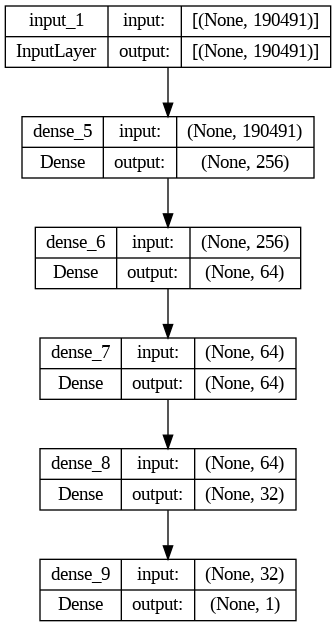

In [ ]:
mlp1 = build_mlp_model1(X_train.shape[1])
plot_model(mlp1, to_file= 'mlp1.png', show_shapes=True, show_layer_names=True)
Image(filename='mlp1.png')

In [ ]:
'''
Train MLP models with incremental Batch Sizes for 4 different batch sizes and
save models only if scores are better than the previous batch size score
'''

score = 1
for i in range(4):
    with timer(f'epoch {i + 1}'):
        his,mod = train_nn(X_train,y_train,X_test,y_test,mlp1,
             "mlp1_epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5",
             2**(8 + i),
             '/content/gdrive/My Drive/Mercari2/log_mlp1',1)
        preds = mod.predict(X_test)[:, 0]
        preds_mlp1 = np.expm1(y_scaler.inverse_transform(preds.reshape(-1, 1))[:, 0])
        print('Test RMSLE for batch size = ',2**(8 + i),' is ',rmsle_score(df_test_model.price.values , preds_mlp1))

        if(score > rmsle_score(df_test_model.price.values , preds_mlp1)):
            score = rmsle_score(df_test_model.price.values , preds_mlp1)
            print('Saving preds_mlp1 for test RMSLE = ',score,'for batch size = ',2**(8+i),'\n')
            file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/model_predictions/preds_mlp1', 'wb')
            pickle.dump(preds_mlp1, file)
            file.close()

4344/4344 [==============================] - ETA: 0s - loss: 0.3590
Epoch 1: val_loss improved from inf to 0.31900, saving model to mlp1_epochs:001-val_loss:0.319.hdf5
11583/11583 [==============================] - 49s 4ms/step
Test RMSLE for batch size =  256  is  0.42301265310064057
Saving preds_mlp1 for test RMSLE =  0.42301265310064057 for batch size =  256 

[epoch 1] done in 3115 s
2172/2172 [==============================] - ETA: 0s - loss: 0.2197
Epoch 1: val_loss improved from inf to 0.31146, saving model to mlp1_epochs:001-val_loss:0.311.hdf5
11583/11583 [==============================] - 34s 3ms/step
Test RMSLE for batch size =  512  is  0.4179848285799123
Saving preds_mlp1 for test RMSLE =  0.4179848285799123 for batch size =  512 

[epoch 2] done in 1433 s
1086/1086 [==============================] - ETA: 0s - loss: 0.1289
Epoch 1: val_loss improved from inf to 0.31445, saving model to mlp1_epochs:001-val_loss:0.314.hdf5
11583/11583 [==============================] - 33s 3

## 13.10 MLP Model 2

In [ ]:
# Generating Data Encodings for MLP
X_train,X_test,y_train,y_test = data_encoder(data_preprocess(df_train_model),data_preprocess(df_test_model))
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1111901, 190491) (370634, 190491) (1111901, 1) (370634, 1)


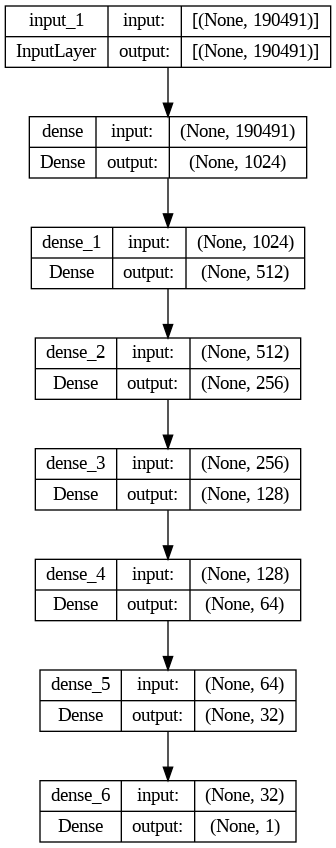

In [ ]:
mlp2 = build_mlp_model2(X_train.shape[1])
plot_model(mlp2, to_file= 'mlp2.png', show_shapes=True, show_layer_names=True)
Image(filename='mlp2.png')

In [ ]:
'''
Train MLP models with incremental Batch Sizes for 4 different batch sizes and
save models only if scores are better than the previous batch size score
'''

score = 1
for i in range(2):
    with timer(f'epoch {i + 1}'):
        his,mod = train_nn(X_train,y_train,X_test,y_test,mlp2,
             "mlp2_epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5",
             2**(8 + i),
             '/content/gdrive/My Drive/Mercari2/log_mlp2',1)
        preds = mod.predict(X_test)[:, 0]
        preds_mlp2 = np.expm1(y_scaler.inverse_transform(preds.reshape(-1, 1))[:, 0])
        print('Test RMSLE for batch size = ',2**(8 + i),' is ',rmsle_score(df_test_model.price.values , preds_mlp2))

        if(score > rmsle_score(df_test_model.price.values , preds_mlp2)):
            score = rmsle_score(df_test_model.price.values , preds_mlp2)
            print('Saving preds_mlp2 for test RMSLE = ',score,'for batch size = ',2**(8+i),'\n')
            file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/model_predictions/preds_mlp2', 'wb')
            pickle.dump(preds_mlp2, file)
            file.close()

4344/4344 [==============================] - ETA: 0s - loss: 0.3609
Epoch 1: val_loss improved from inf to 0.31935, saving model to mlp2_epochs:001-val_loss:0.319.hdf5
11583/11583 [==============================] - 90s 8ms/step
Test RMSLE for batch size =  256  is  0.42324626588022135
Saving preds_mlp2 for test RMSLE =  0.42324626588022135 for batch size =  256 

[epoch 1] done in 10695 s
2172/2172 [==============================] - ETA: 0s - loss: 0.2060
Epoch 1: val_loss improved from inf to 0.30505, saving model to mlp2_epochs:001-val_loss:0.305.hdf5
11583/11583 [==============================] - 100s 9ms/step
Test RMSLE for batch size =  512  is  0.4136630512172524
Saving preds_mlp2 for test RMSLE =  0.4136630512172524 for batch size =  512 

[epoch 2] done in 6022 s


## 13.11 MLP Model 3

In [ ]:
# Generating Data Encodings for MLP
X_train,X_test,y_train,y_test = data_encoder(data_preprocess(df_train_model),data_preprocess(df_test_model))
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1111901, 190491) (370634, 190491) (1111901, 1) (370634, 1)


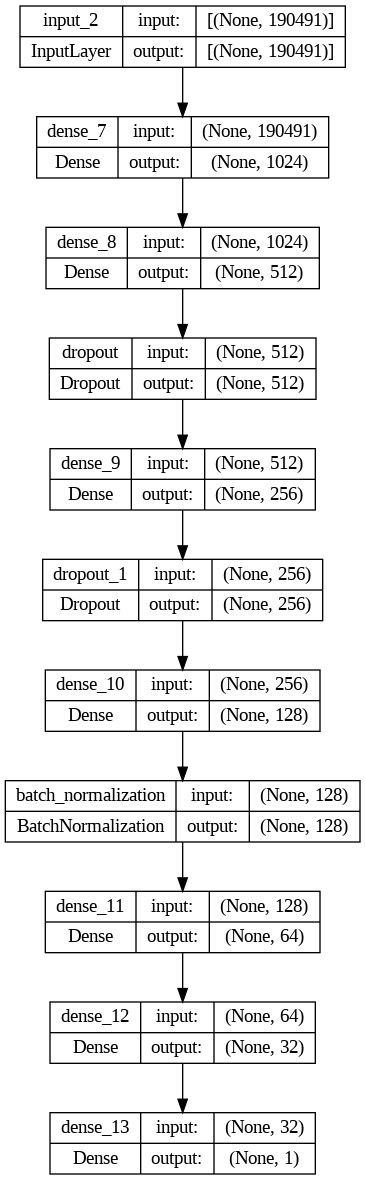

In [ ]:
mlp3 = build_mlp_model3(X_train.shape[1])
plot_model(mlp3, to_file= 'mlp3.png', show_shapes=True, show_layer_names=True)
Image(filename='mlp3.png')

In [ ]:
'''
Train MLP models with incremental Batch Sizes for 4 different batch sizes and
save models only if scores are better than the previous batch size score
'''

score = 1
for i in range(2):
    with timer(f'epoch {i + 1}'):
        his,mod = train_nn(X_train,y_train,X_test,y_test,mlp3,
             "mlp3_epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5",
             2**(8 + i),
             '/content/gdrive/My Drive/Mercari2/log_mlp3',1)
        preds = mod.predict(X_test)[:, 0]
        preds_mlp3 = np.expm1(y_scaler.inverse_transform(preds.reshape(-1, 1))[:, 0])
        print('Test RMSLE for batch size = ',2**(8 + i),' is ',rmsle_score(df_test_model.price.values , preds_mlp3))

        if(score > rmsle_score(df_test_model.price.values , preds_mlp3)):
            score = rmsle_score(df_test_model.price.values , preds_mlp3)
            print('Saving preds_mlp3 for test RMSLE = ',score,'for batch size = ',2**(8+i),'\n')
            file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/model_predictions/preds_mlp3', 'wb')
            pickle.dump(preds_mlp3, file)
            file.close()

3066/4344 [====================>.........] - ETA: 1:03:42 - loss: 0.3926

## 13.12 Weighted Ensemble Regressor

In [ ]:
'''
This code takes the blending predictions formular we use from LGBM and Ridge file
and generates a weighted Prediction : (preds = w1*preds_ridge + w2*preds_lgbm),
weights - w1 and w2 where w2 = (1- w1) are found out using cross validation
that gives lowest RMSLE score
'''

def plot_weight_score(w,s):
    plt.plot(w, s)
    plt.scatter(w, s)
    plt.xlabel("Weights Ratio")
    plt.ylabel("RMSLE")
    plt.title("Weight Selection for Ensemble")
    plt.grid()
    plt.show()

def ensemble_generator(preds1,preds2):
    weights = list(np.linspace(0,1,50))
    scores = []

    for w in tqdm_notebook(weights):
        preds = (w*preds1) + (1-w)*(preds2)
        scores.append(rmsle_score(df_test_model.price.values,preds))

    plot_weight_score(weights,scores)
    df_ens = pd.DataFrame({'weights' : weights,'scores':scores})
    w = df_ens.weights[df_ens.scores == min(df_ens.scores)].values[0]

    preds_final = (w*preds1) + (1-w)*(preds2)
    return preds_final

**Ensembling (MLP 1 + MLP 2)**

In [ ]:
import pickle
file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/model_predictions/preds_ridge1', 'rb')
preds_ridge1 = pickle.load(file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/model_predictions/preds_ridge2', 'rb')
preds_ridge2 = pickle.load(file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/model_predictions/preds_mlp1', 'rb')
preds_mlp1 = pickle.load(file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/model_predictions/preds_mlp2', 'rb')
preds_mlp2 = pickle.load(file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/model_predictions/preds_lgbm2','rb')
preds_lgbm2 = pickle.load(file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/model_predictions/preds_lgbm1','rb')
preds_lgbm1 = pickle.load(file)
file.close()

# file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/model_predictions/preds_mlp3', 'rb')
# preds_mlp3 = pickle.load(file)
# file.close()

  0%|          | 0/50 [00:00<?, ?it/s]

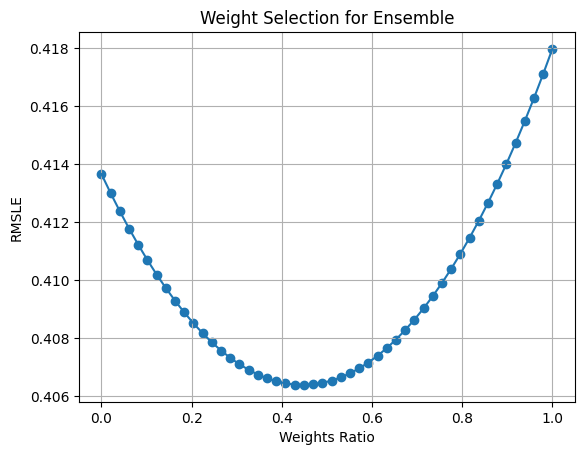

Test RMSLE of Ensemble =  0.4063839300464969


In [ ]:
# Creating Ensemble of (MLP 1 + MLP 2)
preds_final_mlps = ensemble_generator(preds_mlp1,preds_mlp2)
print('Test RMSLE of Ensemble = ',rmsle_score(df_test_model.price.values , preds_final_mlps))

  0%|          | 0/50 [00:00<?, ?it/s]

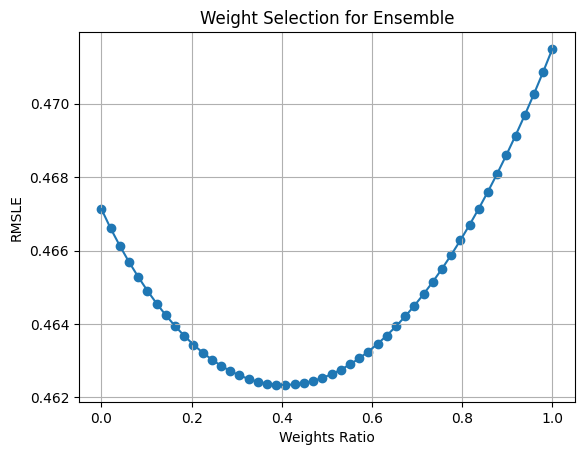

Test RMSLE of Ensemble =  0.46234212037009625


In [ ]:
# Creating Ensemble of (Ridge BOW = Ridge TF-IDF)
preds_final_ridges = ensemble_generator(preds_ridge1,preds_ridge2)
print('Test RMSLE of Ensemble = ',rmsle_score(df_test_model.price.values , preds_final_ridges))

  0%|          | 0/50 [00:00<?, ?it/s]

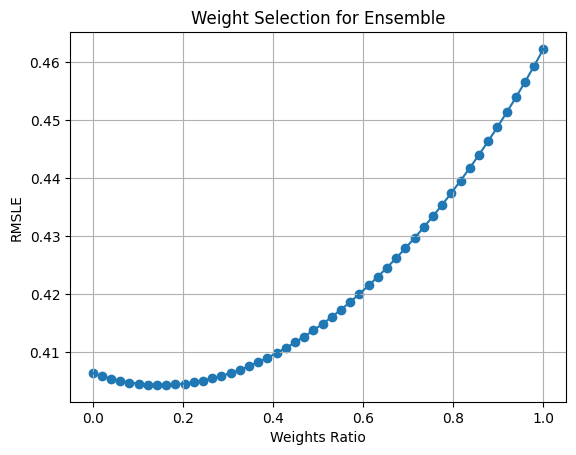

Test RMSLE of Ensemble =  0.40429796651622824


In [ ]:
# Creating Ensemble of (MLP 1 + MLP 2) + (Ridge BOW + Ridge TF-IDF)
preds_final = ensemble_generator(preds_final_ridges,preds_final_mlps)
print('Test RMSLE of Ensemble = ',rmsle_score(df_test_model.price.values , preds_final))

#14. Final Sumamry

## 14.1 PrettyTable Summary of all Models

In [ ]:
x = PrettyTable()
x.field_names = ["Model","Featurizations","Hyperparameters","Test RMSLE"]

x.add_row(["Baseline Ridge","BOW","alpha=10", 0.472])
x.add_row(["Baseline LGBM","BOW","nest=1500,lr=0.05,leaves=50", 0.470])
x.add_row(["Baseline Ensemble=(50% Ridge + 50% LGBM)","BOW","--", 0.460])
x.add_row(["Baseline MLP","Concatenate Text, OneHotEncoding", "batch = 512",0.42])

x.add_row(["----------------","---------------", "---------------","------"])

x.add_row(["Ridge 1","BOW","alpha=10", 0.471])
x.add_row(["Ridge 2","TFIDF","alpha=10", 0.467])
x.add_row(["LGBM 1","BOW","nest=1500,lr=0.05,leaves=50", 0.471])
x.add_row(["LGBM 2","TFIDF","nest=1500,lr=0.05,leaves=50", 0.470])
x.add_row(["MLP 1","256-64-64-32","Adam,Batch=4096", 0.418])
x.add_row(["MLP 2","1024-512-256-128-64-32","Adam,Batch=4096", 0.413])
x.add_row(["MLP 3","MLP2 + BN + dropout","Adam,Batch=4096", 0.415])

x.add_row(["----------------","---------------", "---------------","------"])

x.add_row(["Final Model - Ensemble","MLP 1 + MLP 2 + Ridge 1 + Ridge 2","0.9 MLP + 0.1 Ridge" ,"**0.404**"])

print(x)

+------------------------------------------+-----------------------------------+-----------------------------+------------+
|                  Model                   |           Featurizations          |       Hyperparameters       | Test RMSLE |
+------------------------------------------+-----------------------------------+-----------------------------+------------+
|              Baseline Ridge              |                BOW                |           alpha=10          |   0.472    |
|              Baseline LGBM               |                BOW                | nest=1500,lr=0.05,leaves=50 |    0.47    |
| Baseline Ensemble=(50% Ridge + 50% LGBM) |                BOW                |              --             |    0.46    |
|               Baseline MLP               |  Concatenate Text, OneHotEncoding |         batch = 512         |    0.42    |
|             ----------------             |          ---------------          |       ---------------       |   ------   |
|       

## 14.2 Error Analysis of final Model

In [ ]:
'''
This Code analyzes how the errors between Predicted and Actual are Distributed
'''

In [ ]:
df_errs = pd.DataFrame({'predicted' : preds_final,'actual' : df_test_model.price.values})
df_errs['error'] = df_errs['predicted'] - df_errs['actual']

In [ ]:
# Creating Error Buckets with 5 units difference within (-20,+20) and others..

df_errs['error_slabs'] = pd.cut(df_errs.error, [-20,-15,-10,-5,0,5,10,15,20], include_lowest=True)
df_errs['error_slabs'] = df_errs['error_slabs'].astype(str)
df_errs['error_slabs'][(df_errs['error'] < -20) & (df_errs.error_slabs == 'nan')] = '< -20'
df_errs['error_slabs'][(df_errs['error'] > 20) & (df_errs.error_slabs == 'nan')] = '> 20'
df_errs['abs_error'] = abs(df_errs['error'])
df_errs = df_errs.sort_values(by = 'abs_error',ascending = True).reset_index(drop = True)
df_errs.head(5)

,predicted,actual,error,error_slabs,abs_error
0,28.999981,29.0,-0.000019,"(-5.0, 0.0]",0.000019
1,8.000025,8.0,0.000025,"(0.0, 5.0]",0.000025
2,4.000031,4.0,0.000031,"(0.0, 5.0]",0.000031
3,8.999955,9.0,-0.000045,"(-5.0, 0.0]",0.000045
4,10.000112,10.0,0.000112,"(0.0, 5.0]",0.000112


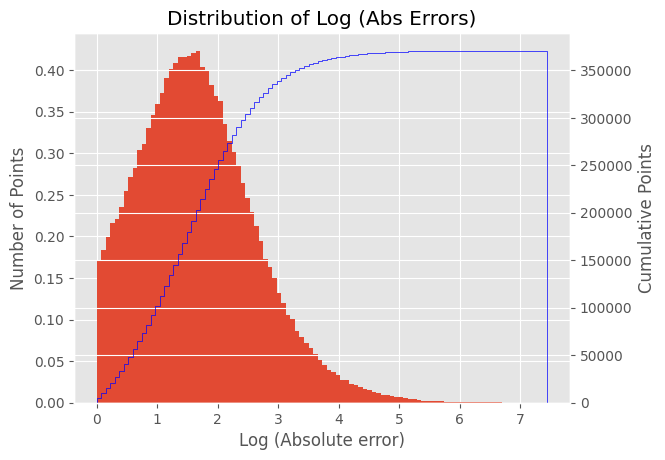

In [ ]:
# Plotting Graph for Distribution of Log(Absolute Error) - PDF and CDF...
plt.style.use('ggplot')
series = pd.Series(np.log1p(df_errs.abs_error))
fig, ax = plt.subplots()
ax2 = ax.twinx()

# Use 'density=True' instead of the deprecated 'normed' argument
n, bins, patches = ax.hist(series, bins=100, density=True)  # Corrected line

n, bins, patches = ax2.hist(series, cumulative=1, histtype='step', bins=100, color='blue')
ax.set_xlabel('Log (Absolute error)')
ax.set_ylabel('Number of Points')
ax2.set_ylabel('Cumulative Points')
plt.title('Distribution of Log (Abs Errors)')
plt.show()  # Add this to display the plot


In [ ]:
'''Code for Grouping Error Slabs'''

tmp_df = pd.DataFrame(df_errs.groupby('error_slabs').agg('size').reset_index())
tmp_df.columns = ['error_slabs','count']
tmp_df['error_slabs'] = pd.Categorical(tmp_df['error_slabs'],
                                       ["< -20", "(-20.001, -15.0]", "(-15.0, -10.0]","(-10.0, -5.0]",
                                        "(-5.0, 0.0]","(0.0, 5.0]","(5.0, 10.0]","(10.0, 15.0]",
                                        "(15.0, 20.0]","> 20"])
tmp_df = tmp_df.sort_values(by=['error_slabs'],ascending = True).reset_index(drop = True)
tmp_df['percent'] = round(tmp_df['count']/sum(tmp_df['count']),4)*100
tmp_df

,error_slabs,count,percent
0,< -20,24351,6.57
1,"(-20.001, -15.0]",9711,2.62
2,"(-15.0, -10.0]",17450,4.71
3,"(-10.0, -5.0]",36812,9.93
4,"(-5.0, 0.0]",93787,25.30
5,"(0.0, 5.0]",120873,32.61
6,"(5.0, 10.0]",40003,10.79
7,"(10.0, 15.0]",13834,3.73
8,"(15.0, 20.0]",5917,1.60
9,> 20,7896,2.13


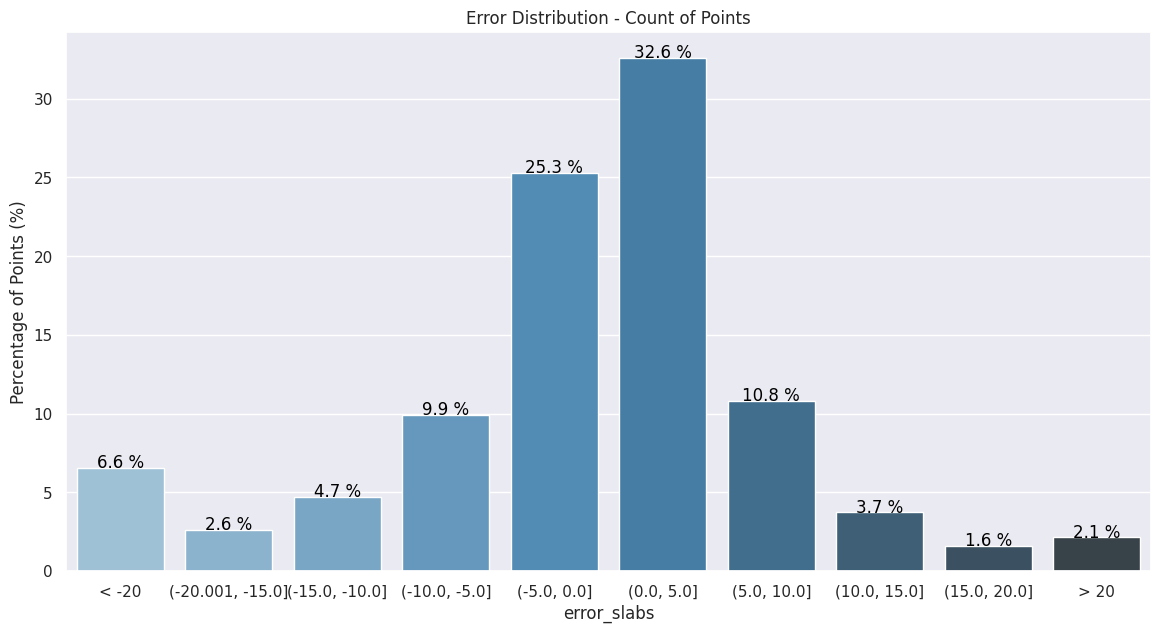

In [ ]:

# Plotting Actual Errors Distribution by generating Histograms..

g = sns.set(rc={'figure.figsize':(14,7)})
g = sns.barplot(x = 'error_slabs',y = 'percent',data = tmp_df,palette="Blues_d")
plt.title('Error Distribution - Count of Points')
plt.ylabel('Percentage of Points (%)')

for index,row in tmp_df.iterrows():
    g.text(row.name,row.percent,str(round(row.percent,1)) + str(' %'), color='black', ha="center")

plt.show()

> **Plot Summary - As we can see, More than 55% of points have errors within (-5,+5) range. More than 75% points have errors within (-10,+10) range**